<a href="https://colab.research.google.com/github/Prasanth217/Forest-Dash-RL/blob/main/Forest_Dash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random

class ForestDashExplorer7x7:
    def __init__(self):
        self.grid_size = 7
        self.max_treasures = 7
        self.max_cooldown = 10
        self.actions = [
            'up', 'down', 'left', 'right',
            'sprint_up', 'sprint_down', 'sprint_left', 'sprint_right',
            'fight', 'avoid'
        ]
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        self.place_items(1, 7, 7)  # 7 caves
        self.place_items(2, 2, 4)  # 2–4 wolves
        self.place_items(3, 2, 4)  # 2–4 fogs
        self.x, self.y = 0, 0
        self.hp = 100
        self.treasures = 0
        self.cooldown = 0
        self.visited = np.zeros((self.grid_size, self.grid_size), dtype=bool)
        self.visited[self.x, self.y] = True
        return self.get_state()

    def place_items(self, item, min_count, max_count):
        count = random.randint(min_count, max_count)
        for _ in range(count):
            while True:
                x, y = random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)
                if self.grid[x, y] == 0 and (x, y) != (0, 0):
                    self.grid[x, y] = item
                    break

    def get_state(self):
        hp_tier = min(self.hp // 20, 4)
        return (self.x, self.y, hp_tier, self.treasures, min(self.cooldown, 9))

    def step(self, action):
        reward = -0.1  # Step cost
        done = False
        steps = 1

        if action.startswith('sprint') and self.cooldown == 0:
            steps = 2
            reward -= 2
            self.hp = max(0, self.hp - 2)
            self.cooldown = self.max_cooldown

        dx, dy = 0, 0
        if 'up' in action: dx = -steps
        elif 'down' in action: dx = steps
        elif 'left' in action: dy = -steps
        elif 'right' in action: dy = steps

        old_x, old_y = self.x, self.y

        self.x = max(0, min(self.grid_size - 1, self.x + dx))
        self.y = max(0, min(self.grid_size - 1, self.y + dy))
        tile = self.grid[self.x, self.y]

        # Rewards based on tile
        if tile == 1:
            reward += 5
            self.treasures += 1
            self.grid[self.x, self.y] = 0
        elif tile == 2:
            if action == 'fight':
                self.hp = max(0, self.hp - 15)
                reward -= 15
                self.grid[self.x, self.y] = 0
            elif action == 'avoid':
                self.hp = max(0, self.hp - 5)
                reward -= 5
        elif tile == 3:
            self.hp = max(0, self.hp - 5)
            reward -= 5
            self.x, self.y = random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)

        # Exploration Rewards
        if not self.visited[self.x, self.y]:
            reward += 2  # Reward for visiting new tile (YOU SAID +2)
            self.visited[self.x, self.y] = True
        else:
            reward -= 1  # Penalty for revisiting tile

        if self.cooldown > 0:
            self.cooldown -= 1

        if self.treasures >= self.max_treasures or self.hp <= 0:
            done = True

        return self.get_state(), reward, done


In [ ]:
Q = np.zeros((7, 7, 5, 8, 10, len(ForestDashExplorer7x7().actions)))
e_trace = np.zeros_like(Q)

# Hyperparameters
alpha = 0.1
gamma = 0.9
lambda_ = 0.7
epsilon = 0.3
epsilon_min = 0.05
epsilon_decay = 0.995
episodes = 2500
rewards = []

env = ForestDashExplorer7x7()


for ep in range(episodes):
    state = env.reset()
    x, y, hp_t, tr, cd = state
    a = random.randint(0, len(env.actions)-1) if random.random() < epsilon else np.argmax(Q[x, y, hp_t, tr, cd])
    e_trace.fill(0)
    total_reward = 0
    done = False

    while not done:
        action = env.actions[a]
        next_state, reward, done = env.step(action)
        nx, ny, nhp_t, ntr, ncd = next_state
        na = random.randint(0, len(env.actions)-1) if random.random() < epsilon else np.argmax(Q[nx, ny, nhp_t, ntr, ncd])

        delta = reward + gamma * Q[nx, ny, nhp_t, ntr, ncd, na] - Q[x, y, hp_t, tr, cd, a]
        e_trace[x, y, hp_t, tr, cd, a] += 1
        Q += alpha * delta * e_trace
        e_trace *= gamma * lambda_

        x, y, hp_t, tr, cd, a = nx, ny, nhp_t, ntr, ncd, na
        total_reward += reward

    rewards.append(total_reward)

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    if (ep + 1) % 100 == 0:
        print(f"Episode {ep + 1}: Total Reward = {total_reward:.2f}")

print("Training complete.")

import pickle

# Save Q-table
with open('qtable_forest_dash.pkl', 'wb') as f:
    pickle.dump(Q, f)

print("✅ Q-table saved successfully!")



Episode 100: Total Reward = -53.70
Episode 200: Total Reward = -209.40
Episode 300: Total Reward = -173.10
Episode 400: Total Reward = -252.90
Episode 500: Total Reward = -235.70
Episode 600: Total Reward = -127.00
Episode 700: Total Reward = -50.70
Episode 800: Total Reward = -109.40
Episode 900: Total Reward = -255.10
Episode 1000: Total Reward = -102.00
Episode 1100: Total Reward = -41.90
Episode 1200: Total Reward = -174.10
Episode 1300: Total Reward = 4.70
Episode 1400: Total Reward = -109.70
Episode 1500: Total Reward = -173.80
Episode 1600: Total Reward = -152.60
Episode 1700: Total Reward = -82.70
Episode 1800: Total Reward = -116.20
Episode 1900: Total Reward = -181.00
Episode 2000: Total Reward = -245.40
Episode 2100: Total Reward = 14.90
Episode 2200: Total Reward = -35.50
Episode 2300: Total Reward = -263.30
Episode 2400: Total Reward = 32.60
Episode 2500: Total Reward = -51.40
Training complete.
✅ Q-table saved successfully!


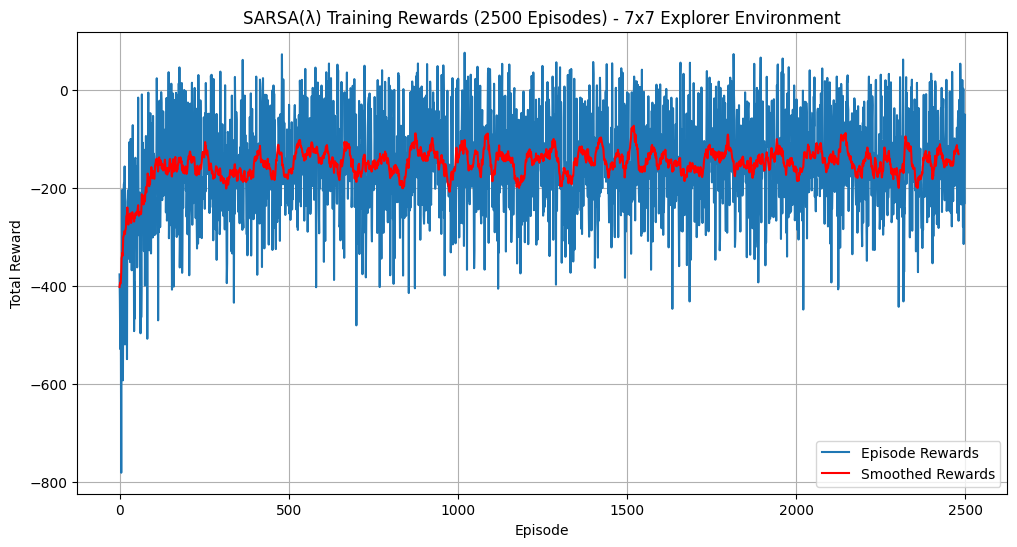

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
plt.plot(rewards, label="Episode Rewards")
plt.plot(np.convolve(rewards, np.ones(20)/20, mode='valid'), label="Smoothed Rewards", color="red")
plt.title("SARSA(λ) Training Rewards (2500 Episodes) - 7x7 Explorer Environment")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.legend()
plt.savefig("rewards_final.png")
plt.show()


In [ ]:
def print_grid(env):
    symbols = {0: '.', 1: 'C', 2: 'W', 3: 'F'}
    grid_output = ""
    for i in range(env.grid_size):
        row = ''
        for j in range(env.grid_size):
            if (i, j) == (env.x, env.y):
                row += 'P '
            else:
                row += symbols.get(env.grid[i, j], '.') + ' '
        grid_output += row + "\n"
    return grid_output

env = ForestDashExplorer7x7()  # 👈 Using 7x7 explorer environment
state = env.reset()
total_reward = 0
done = False
steps = 0
path = []  # Save player movement path
visited_positions = set()
last_position = None
same_position_count = 0

start_pos = (0, 0)  # For curiosity bonus

print("=== FINAL EXPLORER AGENT PLAYING (Ultra Polished) ===\n")

while not done and steps < 100:
    # Save player position
    path.append((env.x, env.y))

    # Print side-by-side
    print(f"Step {steps}: Player Position = {path[-1]}")
    print(print_grid(env))
    print("-" * 50)

    # Choose and take action
    x, y, hp_t, tr, cd = state
    action_index = np.argmax(Q[x, y, hp_t, tr, cd])
    action = env.actions[action_index]

    # Before move
    old_position = (env.x, env.y)

    # Move
    state, reward, done = env.step(action)

    # After move
    new_position = (env.x, env.y)

    # Anti-Stuck (revisiting old tiles)
    if new_position in visited_positions:
        reward -= 0.5
    else:
        visited_positions.add(new_position)

    # ✅ Tiny penalty for standing still
    if new_position == old_position:
        reward -= 0.2

    # ✅ Curiosity bonus for exploring far away
    distance = abs(env.x - start_pos[0]) + abs(env.y - start_pos[1])
    reward += distance * 0.01

    # ✅ Anti-Camping (staying at same tile too long)
    if new_position == last_position:
        same_position_count += 1
    else:
        same_position_count = 0

    # ✅ Increasing punishment if stuck > 3 steps
    if same_position_count > 3:
        reward -= 2 * (2 ** (same_position_count - 3))  # Exponential camping penalty

    last_position = new_position

    # ✅ Anti-Toggling (moving back and forth)
    if len(path) >= 3:
        if path[-1] == path[-3]:
            reward -= 4  # Softer toggling penalty

    total_reward += reward
    steps += 1

if done:
    print("✅ Game ended:", "Won!" if state[2] > 0 else "Lost!")
else:
    print("⚠️ Agent timed out (max 100 steps).")

print(f"\n🏁 Total Reward: {total_reward:.2f}")

# Print full movement path
print("\n📋 Player Full Path (All 100 Steps):")
for idx, pos in enumerate(path):
    print(f"Step {idx}: Position {pos}")


=== FINAL EXPLORER AGENT PLAYING (Ultra Polished) ===

Step 0: Player Position = (0, 0)
P C C . . C . 
. C . . . . . 
. . C . . . . 
. . F W . . . 
. . . . . C . 
. . . . . . . 
C F . W . . F 

--------------------------------------------------
Step 1: Player Position = (1, 0)
. C C . . C . 
P C . . . . . 
. . C . . . . 
. . F W . . . 
. . . . . C . 
. . . . . . . 
C F . W . . F 

--------------------------------------------------
Step 2: Player Position = (3, 0)
. C C . . C . 
. C . . . . . 
. . C . . . . 
P . F W . . . 
. . . . . C . 
. . . . . . . 
C F . W . . F 

--------------------------------------------------
Step 3: Player Position = (4, 0)
. C C . . C . 
. C . . . . . 
. . C . . . . 
. . F W . . . 
P . . . . C . 
. . . . . . . 
C F . W . . F 

--------------------------------------------------
Step 4: Player Position = (5, 0)
. C C . . C . 
. C . . . . . 
. . C . . . . 
. . F W . . . 
. . . . . C . 
P . . . . . . 
C F . W . . F 

----------------------------------------------